In [6]:
import numpy as np
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import config

class MapDataset(Dataset):
    def __init__(self, root_dir):
        super().__init__()

        self.root_dir = root_dir
        self.list_files = os.listdir(root_dir)
        print(self.list_files)
    
    def __len__(self):
        return len(self.list_files)
    
    def __getitem__(self, index):
        image_path = self.list_files[index]
        file_path = os.path.join(self.root_dir, image_path)
        image = np.array(Image.open(file_path))
        input_image = image[:, :256, :]
        inter_image = image[:, 256:512, :]
        target_image = image[:, 512:, :]

        input_image = config.transform_only_input(image=input_image)["image"]
        inter_image = config.transform_only_input(image=inter_image)["image"]
        target_image = config.transform_only_mask(image=target_image)["image"]

        return input_image, inter_image, target_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ls ['img']
input data shape: (128, 128, 14)
data ndvi shape  (128, 128) f_data shape:  (1, 128, 128, 3)


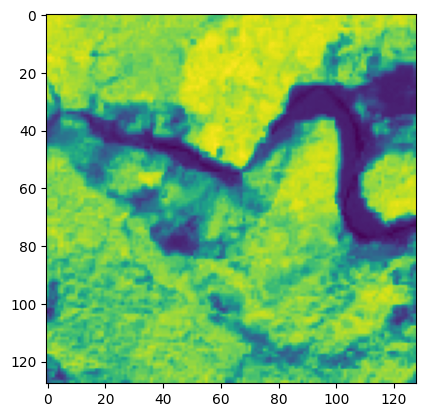

In [25]:

path_single = r"image_dataset/landslide/TrainData/img/image_2000.h5"
path_single_mask = r'image_dataset/landslide/TrainData/mask/mask_2000.h5'

f_data = np.zeros((1, 128,128, 3))
with h5py.File(path_single) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('img'))
    print("input data shape:", data.shape)
    plt.imshow(data[:, :, 3:0:-1])
    
    data_red = data[:, :, 3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]
    data_rgb = data[:, :, 3:0:-1]
    data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
    f_data[0, :, :, 0] =data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]

    print("data ndvi shape ", data_ndvi.shape, "f_data shape: ", f_data.shape)
    plt.imshow(data_ndvi)

ls ['mask']
input data shape: (128, 128)


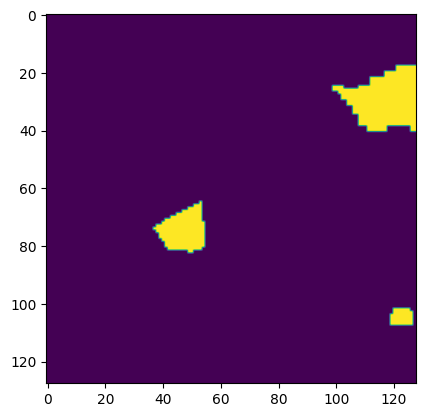

In [26]:
with h5py.File(path_single_mask) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('mask'))
    print("input data shape:", data.shape)
    plt.imshow(data)

In [37]:
import glob

path_single = r"image_dataset/landslide/TrainData/image_10.h5"
path_single_mask = r'image_dataset/landslide/TrainData/mask/mask_1.h5'
TRAIN_PATH = r"image_dataset/landslide/TrainData/img/*.h5"
TRAIN_MASK = r'image_dataset/landslide/TrainData/mask/*.h5'

TRAIN_XX = np.zeros((3799, 128, 128, 7))
TRAIN_YY = np.zeros((3799, 128, 128, 1))
all_train = sorted(glob.glob(TRAIN_PATH))
all_mask = sorted(glob.glob(TRAIN_MASK))

In [ ]:
for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    print(i, img, mask)
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data 
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))

        ndwi = np.divide(data_green - data_nir, data_green + data_nir, 
                 out=np.zeros_like(data_green, dtype=float), 
                 where=(data_green + data_nir) != 0)
        
        # final array
        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED
        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        TRAIN_XX[i, :, :, 3] = data_ndvi #NDVI
        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE
        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION
        TRAIN_XX[i, :, :, 6] = ndwi  #NDWI
    
    
    with h5py.File(mask) as hdf:
        ls = list(hdf.keys())
        data=np.array(hdf.get('mask'))
        TRAIN_YY[i, :, :, 0] = data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


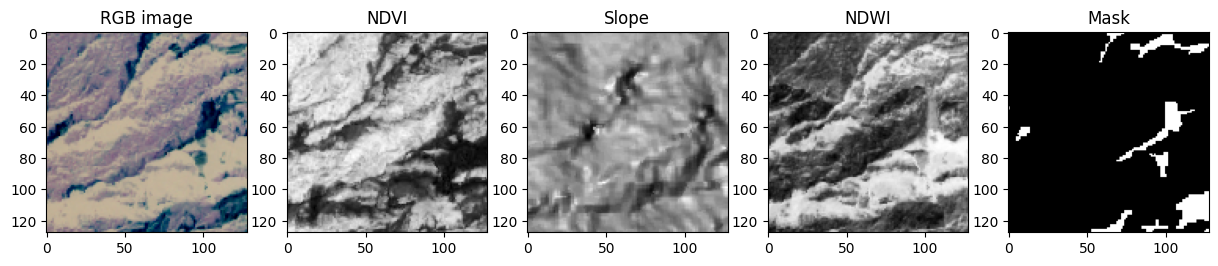

In [43]:
img=234
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax4.set_title("NDWI")
ax5.set_title("Mask")
ax1.imshow(TRAIN_XX[img, :, :, 0:3])
ax2.imshow(TRAIN_XX[img, :, :, 3], cmap="gray")
ax3.imshow(TRAIN_XX[img, :, :, 4], cmap="gray")
ax4.imshow(TRAIN_XX[img, :, :, 5], cmap="gray")
ax4.imshow(TRAIN_XX[img, :, :, 6], cmap="gray")
ax5.imshow(TRAIN_YY[img, :, :, 0], cmap="gray")